## Recreate heatmaps in Figures 3C, S3D, and 5C

In [3]:
import os,sys
import datetime

In [4]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.2 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1
Memory usage: current 0.18 GB, difference +0.00 GB


In [5]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [7]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.7.4


### Load data

In [8]:
adata = sc.read_h5ad('data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

# overwrite obs with the most recent version
adata.obs = rz.load_df('data/obs_info_27563x32_200705_10h46.npz')

(27563, 40930)


,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,...,removed_as_dblt_2,used_in_all_cells_clean_iter2,sp_cl_all_cells_clean_iter2_100,*population,used_in_T_cells_only,archive_population,used_in_all_cells_clean_iter3,sp_cl_all_cells_clean_iter3_100,used_in_T_cells_only_iter2,Major cell type
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,...,False,True,68,B cells,False,mB cells,True,13,False,B cells
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,...,False,True,4,NK cells,False,mNK cells,True,33,False,NK cells
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,...,False,True,75,N4,False,mN4,True,31,False,Neutrophils
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,...,False,True,41,Mac1,False,mMac1,True,18,False,Monocytes/Macrophages
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,...,False,True,1,Mono1,False,mMono1,True,89,False,Monocytes/Macrophages


### Normalize counts to 10k

In [9]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Get unique conditions and populations

In [11]:
adata.obs['condition'].drop_duplicates()

0         CSF1Ri
39600    Vehicle
63980    Healthy
Name: condition, dtype: object

In [1]:
# MoMacDC are all bunched together for the major cell types
adata.obs[['Major cell type', '*population']].drop_duplicates()

### Generate new labels for metadata and average expression

In [13]:
# dictionary for friendlier labels
cond_f = {"CSF1Ri":"+", "Vehicle":"-", "Healthy":"x"}
cpdb_pops = {"Mono1":"MoMac", "Mono2":"MoMac", "Mono3":"MoMac", 
             "MonoDC":"MonoDC", "Mac1":"MoMac", 
             "Mac2":"MoMac", "Mac3":"MoMac", "Mac4":"MoMac",
             "DC1":"DC1", "DC2":"DC2", "DC3":"DC3", "pDC":"pDC",
             "T_Cd4":"NK/T", "T_Cd8":"NK/T", "T_gd":"T_gd", "T_reg":"Treg",
             "NK cells":"NK/T",
             "Plasma_cells":"B", "B cells":"B", "Basophils":"Basophils", "ILC":"ILC",
             "N1":"Neutrophils", "N2":"Neutrophils", "N3":"Neutrophils", "N4":"Neutrophils",
             "N5":"Neutrophils", "N6":"Neutrophils"}

# Generate new label combining *population and condition
adata.obs['*pop+cond'] = adata.obs['*population'].map(cpdb_pops).map(str) + ' ' + [cond_f[i] for i in adata.obs['condition']]

# get mean exp
cmask = adata.obs['used_in_all_cells_clean_iter3'].astype(bool).values
centroids = rz.centroids('*pop+cond',adata[cmask])

### Import genes, select which to include in heatmap

In [24]:
pops = ['DC1 -', 'DC1 +', 
        'DC2 -', 'DC2 +', 
        'DC3 -', 'DC3 +', 
        'NK/T -', 'NK/T +']   

# mapping of names to index for sorting later
popdict = {}
x = 1
for p in pops:
    popdict[p] = x
    x += 1

In [25]:
# make dictionary of interacting pairs (preserving order) and activating ligands and receptors
fname = "Aug20_BLZ_data/cpdb_results/Interactions_UP-DC1-3_Aug20.txt"

pairs_ints = {}
for line in open(fname):
    line = line.rstrip('\n').split('\t')
    pair = line[5]
    lr = line[0]
    ann = line[9]
    if pair not in pairs_ints:
        pairs_ints[pair] = []
    if ann == "A":
        pairs_ints[pair].append(lr)
            
for p in pairs_ints:
    print(p)
    print(pairs_ints[p])

pair
[]
DC1.NK/T
['Pdgfb_S1pr1', 'Gnai2_S1pr5']
NK/T.DC1
['Cd28_Cd80', 'Cd28_Cd86', 'Xcl1_Xcr1', 'Cd28_Cd86', 'Ifng_Ifngr2', 'Xcl1_Xcr1']
DC2.NK/T
['Cxcl16_Cxcr6', 'Pdgfb_S1pr1', 'Fas_Fasl', 'Gnai2_S1pr5']
NK/T.DC2
['Cd28_Cd80', 'Cd28_Cd86', 'Xcl1_Xcr1', 'Ifng_Ifngr1', 'Ifng_Ifngr2']
DC3.NK/T
['Pdgfb_S1pr1', 'Sdc4_Ccl5', 'Gnai2_S1pr5', 'Il12b_Il12rb2']
NK/T.DC3
['Ifng_Ifngr1', 'Ifng_Ifngr2']


In [146]:
# for cell type pair, return genes that are in master list of interactions to include
include = ['Cd28_Cd80', 'Cd28_Cd86', 'Ifng_Ifngr1', 
           'Ifng_Ifngr2', 'Il12b_Il12rb2', 'Xcl1_Xcr1']

def lookup(pop1, pop2, dic, include):
    pair1 = pop1 + "." + pop2
    pair2 = pop2 + "." + pop1
    tmp = []
    for p in [pair1, pair2]:
        for i in dic[p]:
            if i in include:
                tmp.append(i)
    genes = []
    for i in tmp:
        genes.extend(i.split("_"))
    return genes

genes = lookup("NK/T", "DC1", pairs_ints, include)
uniq_gs = [g for g in set(genes)] 

print(genes)

['Ifng', 'Ifngr1', 'Ifng', 'Ifngr2', 'Il12b', 'Il12rb2']


In [174]:
genes = ['Xcl1', 'Xcr1', 'Ifng', 'Ifngr2']
uniq_gs = [g for g in set(genes)]

In [175]:
# pseudovalue used in Immunity paper was 50 tpm, i.e. 0.5 count per 10k.
## here, we use 100 TPM or 1 count per 10k
pseudo = 1

figkey = "NK.T-DC1_HM_CP10Kmedian_Aug20"
genes_to_plot = genes

# color map palette
cmap = plt.cm.get_cmap('RdBu_r')
# graphic parameters
thelim = 2
mfont = {'fontname':'MyriadPro'}

In [177]:
# transform the data (CPKref here is median)
heat = centroids.loc[pops,uniq_gs] + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

# sort the data
heat.loc['which'] = [popdict[i] for i in heat.idxmax()]
heat.loc['max'] = heat.loc[pops].max()
heat = heat.sort_values(by=['which', 'max'], axis=1, ascending=False)
heat = heat.loc[pops]

In [178]:
# add new columns to define index - for HM labeling
heat['group'] = [i.split()[0] for i in heat.index]
heat['subgroup'] = [i.split()[1] for i in heat.index]

In [179]:
heat.set_index(['group','subgroup'], inplace=True)
heat

index               Xcl1      Ifng      Xcr1    Ifngr2
group subgroup                                        
DC1   -        -0.010623 -0.007533  2.177939  0.003781
      +        -0.010623 -0.007533  2.823491  0.418446
DC2   -        -0.010623  0.007494  0.066849 -0.003791
      +         0.010545 -0.007533  0.207661 -0.094982
DC3   -        -0.010623 -0.007533 -0.128249  0.025702
      +         0.012862  0.010098 -0.070098  0.226848
NK/T  -         1.129080  0.595242 -0.108512 -0.490418
      +         1.777865  1.055830 -0.104317 -0.413732

### Formatting heatmaps 

In [180]:
def xticks_fancy(a,totick,labels_all,emptychar = '',fontsize=5):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: xticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """

    a.set_xticks([])
    leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    #if genes were not typed in in the correct order, account for that to avoid lines crossing
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((r,r),(-0.8-leftshift,-0.5-leftshift),lw=0.5,color='0.2')
        a.plot((l,r),(-1.2-leftshift,-0.8-leftshift),lw=0.5,color='0.2')
        a.plot((l,l),(-1.5-leftshift,-1.2-leftshift),lw=0.5,color='0.2')
        a.text(l,-1.6-(leftshift*1.6),gene,ha='center',va='bottom',fontsize=fontsize, rotation='vertical')

In [181]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos + 1.15, xpos], [ypos, ypos],
                      transform=ax.transAxes, color='gray', lw=0.7)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in itertools.groupby(labels)]

def label_group_hm(ax, df):
    xpos = -.3
    scale = 1./df.index.size
    ha = 'center'
    for level in range(df.index.nlevels)[::-1]:
        pos = a.get_ylim()[0]+0.5
        for label, rpos in label_len(df.index,level):
            lypos = (pos - .6*rpos)*scale
            if level == 0:
                ha = 'right'
            if label == "NK/T":
                ax.text(xpos, lypos, label, ha=ha, transform=ax.transAxes, 
                        fontweight="bold", color="red")
            elif label == "DC1" or label == "DC1":
                ax.text(xpos, lypos, label, ha=ha, transform=ax.transAxes, 
                        fontweight="bold", color="blue")
            elif label == "DC2" or label == "DC3":
                ax.text(xpos, lypos, label, ha=ha, transform=ax.transAxes, 
                        color="grey")
            else:    
                ax.text(xpos, lypos, label, ha=ha, transform=ax.transAxes)
            pos -= rpos
        xpos -= .3      

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


/Users/angela/Downloads/NK.T-DC1_HM_CP10Kmedian_Aug20


'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


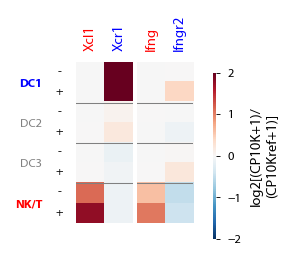

In [182]:
# plot heatmap
h = heat.shape[1]/150.+4
w = heat.shape[0]*0.3+1.2
# w = heat.shape[0]*0.3+1.2
fig,gs = rz.startfig(w,h,columns=len(genes)//2,return_first_ax=False)
  
# for saving heatmaps as separate excel sheets
fname = 'output/%s'%figkey
print(fname)

for i in range(len(genes)//2):
    a = fig.add_subplot(gs[0,i])
    im = a.matshow(heat.loc[:,[genes[2*i],genes[2*i+1]]],vmin=-thelim,vmax=thelim,cmap=cmap,aspect='auto')
    rz.showspines(a)
    a.set_xticklabels([genes[2*i], genes[2*i],genes[2*i+1]], fontsize=7, rotation='vertical')
    labs = [t for t in a.get_xticklabels()]
    labs[1].set_color("red")
    labs[2].set_color("blue")
#     if i == 2:
#         labs[2].set_color("red")
#         labs[1].set_color("blue")
    a.set_yticklabels('')
    if i == 0:
        label_group_hm(a, heat) 
    for n in [5.5,3.5,1.5]:
        a.axhline(y=n,xmin=0,xmax=1,linewidth=0.5,c="grey")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.0, 0.015, 0.7])

cbar = fig.colorbar(im, cax = cbar_ax)
cbar.outline.set_visible(False)
cbar.set_label('log2[(CP10K+1)/\n(CP10Kref+1)]',fontsize=7)
plt.tight_layout(h_pad=0,w_pad=0)

plt.savefig('%s.pdf'%fname, bbox_inches='tight')
plt.show()  